In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from urllib.request import urlopen

# 29. [Easy] Gas Prices and Deposit/Borrow Amounts

**Bounty:** As gas prices have continued to rise, how have average deposit and borrow amounts changed in response?

**Conculsion**:  
Over the past year gas prices have been on the rise. They have risen dramatically in the native gwei and even more so in USD as the ETH/USD price continues to climb.  
  
I compared the distribution of deposit and borrow sizes above and below the median gas prices in both currencies and found the following:  
* As gas prices rise in terms of gwei there is no significant change in either average deposit or borrow size  
* As gas prices rise in terms of USD it seems that the average deposit or borrow size tends to increase  


## Pull the data

We're going to query the `aave` dataset and calculate the daily average Deposit and Borrow amounts. We'll also join in the `ethereum` table where we can calcuate the average daily gas fees. We'll collect those gas fees both in USD (which is what we'll be looking at Aave Deposits and Borrows in) as well as Gwei.


In [2]:
query = '''
-- As gas prices have continued to rise, how have average deposit and borrow amounts changed in response?
WITH avgDeposits AS(
  SELECT
  DATE(ad.BLOCK_TIMESTAMP) as date,
  AVG(ad.SUPPLIED_USD) as avgDepositUSD
  FROM aave.deposits ad
  GROUP BY DATE(ad.BLOCK_TIMESTAMP)
), avgBorrows AS (
  SELECT
  DATE(ab.BLOCK_TIMESTAMP) as date,
  AVG(ab.BORROWED_USD) as avgBorrowUSD
  FROM aave.borrows ab
  GROUP BY DATE(ab.BLOCK_TIMESTAMP) 
), avgGas AS (
  SELECT
  DATE(e.BLOCK_TIMESTAMP) as date,
  AVG(e.GAS_PRICE)/1000000000 as avgFeeWGEI,
  AVG(FEE_USD) as avgFeeUSD
  FROM ethereum.transactions e
  GROUP BY DATE(e.BLOCK_TIMESTAMP)
)
SELECT
d.*,
b.avgBorrowUSD,
g.avgFeeWGEI,
g.avgFeeUSD
FROM avgDeposits d
LEFT JOIN avgBorrows b on b.date = d.date
LEFT JOIN avgGas g on g.date = d.date

'''

In [3]:
# Pull query data from API 

url = 'https://api.flipsidecrypto.com/api/v2/queries/64125e5f-b463-4d4a-8606-1be4e54b2ca9/data/latest'

response = urlopen(url)
data_json = json.loads(response.read())
df = pd.DataFrame(data_json)

In [4]:
# Clean the df
df['DATE'] = pd.to_datetime(df['DATE'], utc =True)
df = df[df['DATE'] > pd.to_datetime('2021-01-01', utc=True)]
df.sort_values('DATE', inplace=True)

## Plot the Data

### Deposits

#### Raw Value Plots

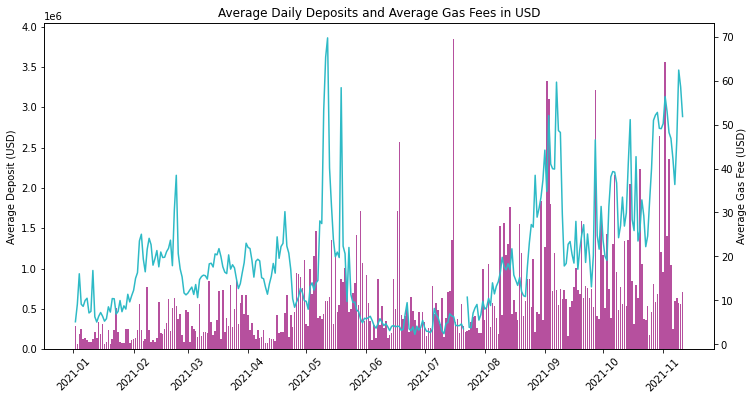

In [5]:
# Plot fees in USD over deposits

fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()
ax1.bar(df['DATE'], df['AVGDEPOSITUSD'], color='#B6509E')
ax2.plot(df['DATE'], df['AVGFEEUSD'], color='#2EBAC6')

ax1.tick_params(axis="x", labelbottom=True, rotation=45)
ax1.set_ylabel('Average Deposit (USD)')
ax2.set_ylabel('Average Gas Fee (USD)')

plt.title('Average Daily Deposits and Average Gas Fees in USD')
plt.show()

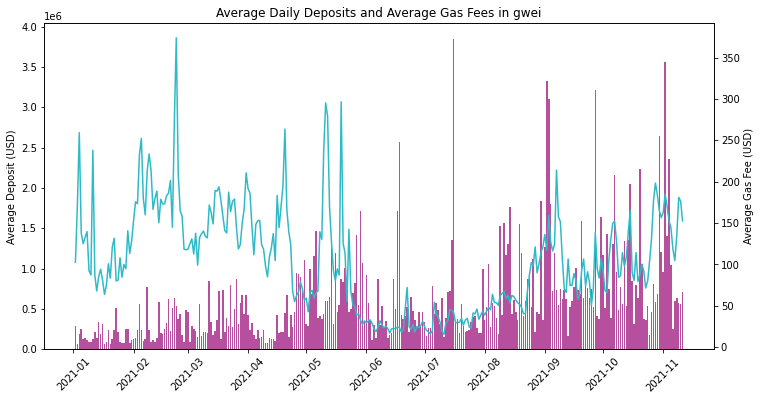

In [6]:
# Plot fees in gwei over deposits 

fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()
ax1.bar(df['DATE'], df['AVGDEPOSITUSD'], color='#B6509E')
ax2.plot(df['DATE'], df['AVGFEEWGEI'], color='#2EBAC6')

ax1.tick_params(axis="x", labelbottom=True, rotation=45)
ax1.set_ylabel('Average Deposit (USD)')
ax2.set_ylabel('Average Gas Fee (USD)')

plt.title('Average Daily Deposits and Average Gas Fees in gwei')
plt.show()

Just looking at the data, it seems like average daily deposits is increasing as the gas fees increase. We’ll take a look at some of the distributions of deposits over and under a given gas fee threshold to see if there a significant difference.

#### Distribution Plots

In [7]:
df['AVGFEEUSD'].median()

16.25451117502606

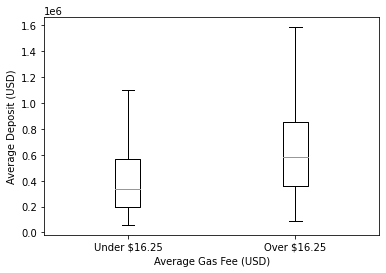

In [8]:
# Box Plot of the distrubtion of average deposits over and under a given gas fee threshold in USD

cutoff = 16.25

under = df[df['AVGFEEUSD'] < cutoff]['AVGDEPOSITUSD']
over = df[df['AVGFEEUSD'] >= cutoff]['AVGDEPOSITUSD']


data = [under, over]

fig, ax = plt.subplots()

pos = np.arange(len(data)) + 1
bp = ax.boxplot(data, positions=pos, showfliers=False,
                labels= [f'Under ${str(cutoff)}',
                         f'Over ${str(cutoff)}'])

ax.set_xlabel('Average Gas Fee (USD)')
ax.set_ylabel('Average Deposit (USD)')
plt.show()

In [9]:
df['AVGFEEWGEI'].median()

98.00093605718081

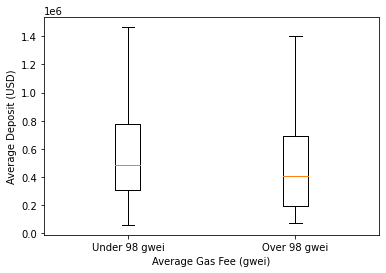

In [10]:
# Box Plot of the distrubtion of average deposits over and under a given gas fee threshold in gwei

cutoff = 98

under = df[df['AVGFEEWGEI'] < cutoff]['AVGDEPOSITUSD']
over = df[df['AVGFEEWGEI'] >= cutoff]['AVGDEPOSITUSD']


data = [under, over]

fig, ax = plt.subplots()

pos = np.arange(len(data)) + 1
bp = ax.boxplot(data, positions=pos, showfliers=False,
                labels= [f'Under {str(cutoff)} gwei',
                         f'Over {str(cutoff)} gwei'])

ax.set_xlabel('Average Gas Fee (gwei)')
ax.set_ylabel('Average Deposit (USD)')
plt.show()

Looking at these two boxplots, it’s possible that the average deposit size may be increasing while the gas fees increase in terms of USD. However the distribution looks to be about the same while gas fees increase in terms of gwei.

### Borrows

#### Raw Value Plots

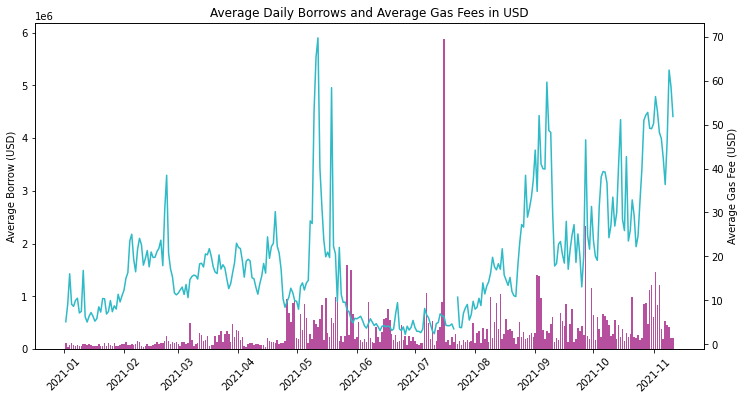

In [11]:
# Plot fees in USD over borrows

fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()
ax1.bar(df['DATE'], df['AVGBORROWUSD'], color='#B6509E')
ax2.plot(df['DATE'], df['AVGFEEUSD'], color='#2EBAC6')

ax1.tick_params(axis="x", labelbottom=True, rotation=45)
ax1.set_ylabel('Average Borrow (USD)')
ax2.set_ylabel('Average Gas Fee (USD)')

plt.title('Average Daily Borrows and Average Gas Fees in USD')
plt.show()

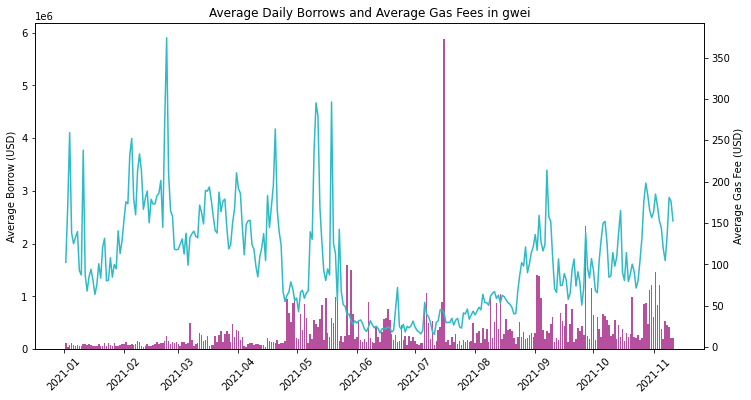

In [12]:
# Plot fees in gwei over borrows 

fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()
ax1.bar(df['DATE'], df['AVGBORROWUSD'], color='#B6509E')
ax2.plot(df['DATE'], df['AVGFEEWGEI'], color='#2EBAC6')

ax1.tick_params(axis="x", labelbottom=True, rotation=45)
ax1.set_ylabel('Average Borrow (USD)')
ax2.set_ylabel('Average Gas Fee (USD)')

plt.title('Average Daily Borrows and Average Gas Fees in gwei')
plt.show()

Just looking at the data, it doesn’t seem that the average daily borrows are effected by a change in gas fees. We’ll take a look at some of the distributions of deposits over and under a given gas fee threshold to see if there a significant difference.

#### Distribution Plots

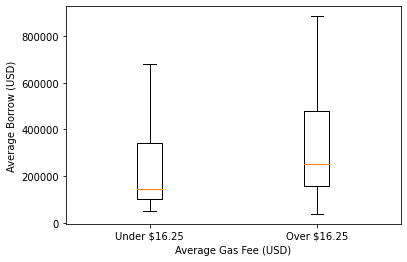

In [13]:
# Box Plot of the distrubtion of average borrows over and under a given gas fee threshold in USD

cutoff = 16.25

under = df[df['AVGFEEUSD'] < cutoff]['AVGBORROWUSD']
over = df[df['AVGFEEUSD'] >= cutoff]['AVGBORROWUSD']


data = [under, over]

fig, ax = plt.subplots()

pos = np.arange(len(data)) + 1
bp = ax.boxplot(data, positions=pos, showfliers=False,
                labels= [f'Under ${str(cutoff)}',
                         f'Over ${str(cutoff)}'])

ax.set_xlabel('Average Gas Fee (USD)')
ax.set_ylabel('Average Borrow (USD)')
plt.show()

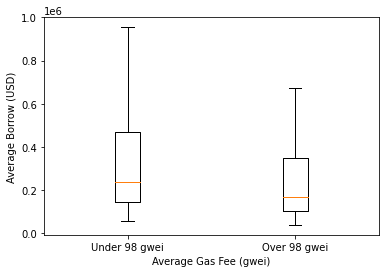

In [14]:
# Box Plot of the distrubtion of average borrows over and under a given gas fee threshold in gwei

cutoff = 98

under = df[df['AVGFEEWGEI'] < cutoff]['AVGBORROWUSD']
over = df[df['AVGFEEWGEI'] >= cutoff]['AVGBORROWUSD']


data = [under, over]

fig, ax = plt.subplots()

pos = np.arange(len(data)) + 1
bp = ax.boxplot(data, positions=pos, showfliers=False,
                labels= [f'Under {str(cutoff)} gwei',
                         f'Over {str(cutoff)} gwei'])

ax.set_xlabel('Average Gas Fee (gwei)')
ax.set_ylabel('Average Borrow (USD)')
plt.show()

Looking at these two boxplots, it’s possible that the average borrow size may be increasing while the gas fees increase in terms of USD. However the distribution looks to be about the same while gas fees increase in terms of gwei.